# NREL_multi_task
- `Message-passing neural networks for high-throughput polymer screening`の追試
- Related DOI: https://doi.org/10.1063/1.5099132
- 目的変数8個を同時に予測するGNNを構築

### Results (Test, raw scale)
- 論文の2倍程度予測精度が悪かったが、桁は同じ。

| Task | 論文(MAE) | 今回の実装(MAE) |
|-----|------|-----|
| gap | 35.4 | 74.8 |
| HOMO | 29.4| 59.6 |
| LUMO   | 29.2 | 68.4 |
| spectral overlap   | 149.2 | 254.5
| Polymer HOMO   | 47.4 | 74.2
| Polymer LUMO   | 46.8 | 76.3
| Polymer gap   | 56.3 | 88.0
| Pol. optical LUMO   | 43.9 | 73.6

### Discussion
- データセット分割方法が異なるなどが原因で予測精度がずれたか。

## ライブラリ読み込み

In [1]:
import sys
import copy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from rdkit import Chem
from rdkit import __version__ as rdkit_version
from rdkit.Chem import Draw

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_add_pool
import torch_geometric

from tqdm import tqdm

import os
import json
from typing import List, Dict, Any, Tuple, Optional, Callable

# ------------------------------
# Reproducibility
# ------------------------------
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ------------------------------
# Device
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Environment info (for reproducibility)
# ------------------------------
print("===== Environment =====")
print(f"Python           : {sys.version.split()[0]}")
print(f"PyTorch          : {torch.__version__}")
print(f"PyTorch Geometric: {torch_geometric.__version__}")
print(f"RDKit            : {rdkit_version}")
if torch.cuda.is_available():
    print(f"CUDA version     : {torch.version.cuda}")
print("========================")
print("device:", device)

===== Environment =====
Python           : 3.9.23
PyTorch          : 2.2.1+cu121
PyTorch Geometric: 2.6.1
RDKit            : 2025.03.5
CUDA version     : 12.1
device: cuda


## データセット読み込み

In [2]:
# ダウンロードしたデータセットを読み込む
dataset_train = pd.read_csv("data/NREL/smiles_train.csv.gz", index_col=0)
dataset_val = pd.read_csv("data/NREL/smiles_valid.csv.gz", index_col=0)
dataset_test = pd.read_csv("data/NREL/smiles_test.csv.gz", index_col=0)

# 全部くっつける
dataset_full = pd.concat([dataset_train, dataset_val, dataset_test], axis=0)

print("Train dataset size:", len(dataset_train))
print("Validation dataset size:", len(dataset_val))
print("Test dataset size:", len(dataset_test))
print("Full dataset size:", len(dataset_full))

Train dataset size: 80823
Validation dataset size: 5000
Test dataset size: 5000
Full dataset size: 90823


In [3]:
# データセットの最初の数行を表示
dataset_full.head()

,smile,gap,homo,lumo,spectral_overlap,homo_extrapolated,lumo_extrapolated,gap_extrapolated,optical_lumo_extrapolated
0,COc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5sc(-c6ccc(-c7c...,1.5970,-4.924172,-3.087676,14347.820013,NaN,NaN,NaN,NaN
1,Cc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5sc(-c6ccc(-c7cc...,1.6331,-5.017235,-3.125227,14595.258114,NaN,NaN,NaN,NaN
2,COc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5sc(-c6ccc(C7=C...,1.6037,-4.939683,-3.093662,15232.630996,NaN,NaN,NaN,NaN
3,Cc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5sc(-c6ccc(C7=CC...,1.6539,-5.039548,-3.118697,15155.591515,NaN,NaN,NaN,NaN
4,COc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5sc(-c6ccc(-c7c...,1.5066,-4.915464,-3.142098,14478.411023,NaN,NaN,NaN,NaN


In [4]:
# SMILES列
smiles_col = 'smile'

# 目的変数列（8個）
target_cols = ["gap", "homo", "lumo", "spectral_overlap", "homo_extrapolated", "lumo_extrapolated", "gap_extrapolated", "optical_lumo_extrapolated"]
required_cols = [smiles_col] + target_cols

# 必須列の欠損チェック
missing_cols = [c for c in required_cols if c not in dataset_full.columns]
if missing_cols:
    raise ValueError(f"dataset_full に必要列がありません: {missing_cols}. columns={list(dataset_full.columns)}")

# 目的変数列が欠損している行を除外
df = dataset_full[required_cols].dropna().reset_index(drop=True)

# 型の安全化（smileはstr、ターゲットはnumeric）
df["smile"] = df["smile"].astype(str)
for col in target_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=target_cols).reset_index(drop=True)

print("Usable rows:", len(df))
display(df.head(3))

Usable rows: 54335


,smile,gap,homo,lumo,spectral_overlap,homo_extrapolated,lumo_extrapolated,gap_extrapolated,optical_lumo_extrapolated
0,CC(C)(C)c1cc(Cc2ccc(-c3c4cc(-c5cc6c(-c7ccc(Cc8...,2.8229,-4.976962,-1.834319,1565.417406,-4.693964,-2.430793,1.9479,-2.746064
1,COP(=O)(OC)Oc1ccc(-c2c3cc(-c4cc5c(-c6ccc(Cc7cc...,2.8338,-5.083087,-1.922212,1427.499693,-4.770156,-2.532291,1.9418,-2.828356
2,Cc1sc(C)c2c3cc(-c4sc(-c5cc6c(-c7ccc(C(F)(F)C(F...,2.2093,-5.022949,-2.551067,4052.235421,-4.835191,-2.961959,1.5615,-3.273691


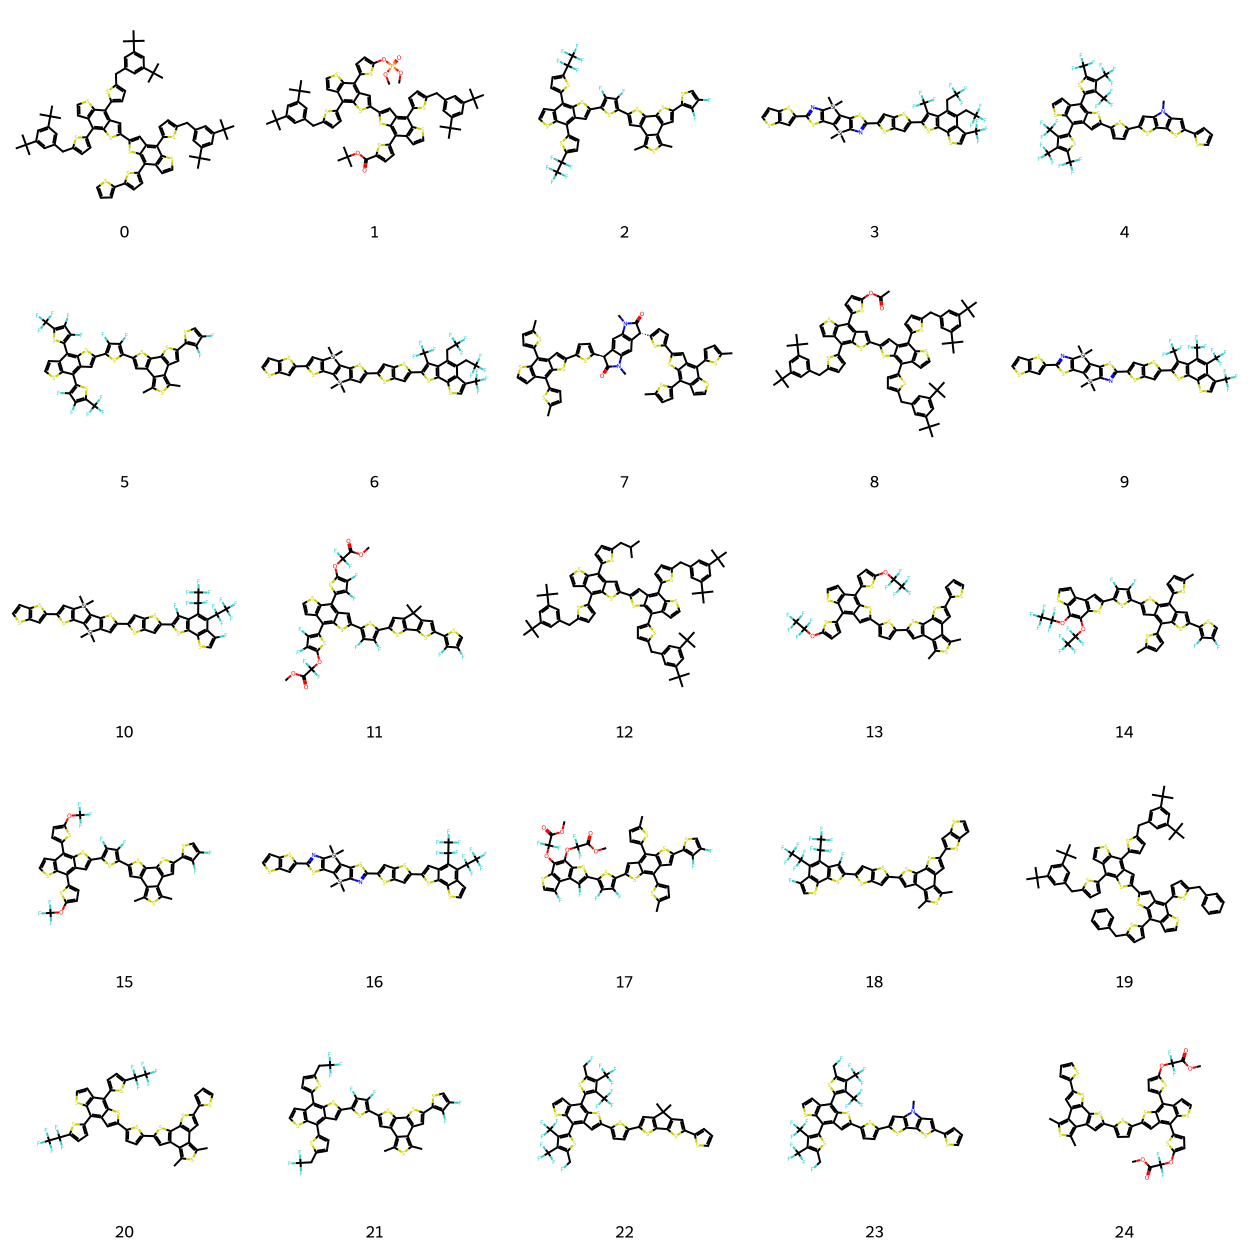

In [5]:
# 25分子を grid 形式で可視化（RDKit）

# Mol生成（失敗したSMILESはNoneになる）
mols = []
legends = []
for i, smi in enumerate(df[smiles_col].astype(str).head(25)):
    m = Chem.MolFromSmiles(smi)
    mols.append(m)
    legends.append(f"{i}")

# 表示
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=5,
    subImgSize=(250, 250),
    legends=legends
)
display(img)

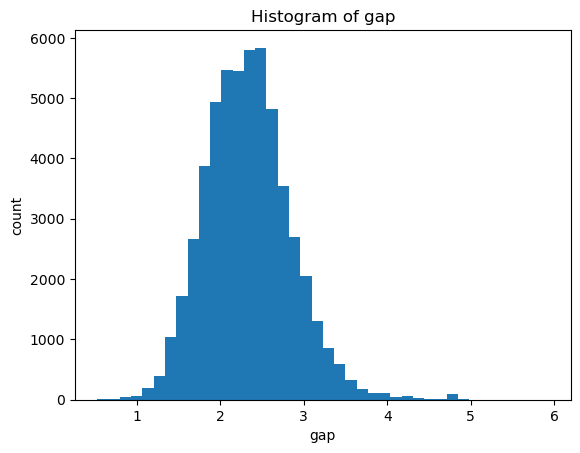

count: 54335
min / max: 0.5283 5.9262
mean / std: 2.3321466936597037 0.512168096084987
quantiles: {0.01: 1.291238, 0.05: 1.556, 0.5: 2.3128, 0.95: 3.1898299999999997, 0.99: 3.7101659999999996}


In [6]:
# 目的変数の可視化

# 目的変数のselect
target_col = "gap"
if target_col not in df.columns:
    raise ValueError(f"'{target_col}' 列がありません。利用可能列: {list(df.columns)}")

X = df[target_col].dropna()

plt.figure()
plt.hist(X, bins=40)
plt.title(f"Histogram of {target_col}")
plt.xlabel(f"{target_col}")
plt.ylabel("count")
plt.show()

print("count:", len(X))
print("min / max:", float(X.min()), float(X.max()))
print("mean / std:", float(X.mean()), float(X.std()))
print("quantiles:", X.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).to_dict())

In [7]:
# ============================================================
# Hold-out split: train / val / test（ランダム分割）
# ============================================================

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,          # 全体の 20% を val + test に回す
    random_state=SEED,
    shuffle=True,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,          # temp の半分ずつ -> 各 10%
    random_state=SEED,
    shuffle=True,
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(
    "Hold-out split sizes ->",
    "train:", len(train_df),
    "val:", len(val_df),
    "test:", len(test_df),
)

# ============================================================
# Robust scaling: median = 0, IQR = 1（train のみで fit）
# ============================================================

def fit_robust_scaler(y: pd.Series):
    y = y.astype(float)
    med = float(y.median())
    q1 = float(y.quantile(0.25))
    q3 = float(y.quantile(0.75))
    iqr = q3 - q1
    if iqr == 0:
        iqr = 1.0
    return med, iqr

def transform_robust(y: pd.Series, med: float, iqr: float):
    return (y.astype(float) - med) / iqr

def inverse_robust(y_scaled, med: float, iqr: float):
    return y_scaled * iqr + med


# ---- train のみで fit ----
scalers = {col: fit_robust_scaler(train_df[col]) for col in target_cols}

# ---- 各 split に適用（コピーしてから列追加）----
train_df = train_df.copy()
val_df   = val_df.copy()
test_df  = test_df.copy()

for col in target_cols:
    med, iqr = scalers[col]
    train_df[f"{col}_scaled"] = transform_robust(train_df[col], med, iqr)
    val_df[f"{col}_scaled"]   = transform_robust(val_df[col],   med, iqr)
    test_df[f"{col}_scaled"]  = transform_robust(test_df[col],  med, iqr)

# ---- 確認ログ（ターゲット毎）----
for col in target_cols:
    med, iqr = scalers[col]
    q1 = float(train_df[f"{col}_scaled"].quantile(0.25))
    q3 = float(train_df[f"{col}_scaled"].quantile(0.75))
    print(
        f"[fit on train] {col}: median(raw)={med:.5g}, IQR(raw)={iqr:.5g} | "
        f"median(scaled)={float(train_df[f'{col}_scaled'].median()):.5g}, IQR(scaled)={(q3-q1):.5g}"
    )

Hold-out split sizes -> train: 43468 val: 5433 test: 5434
[fit on train] gap: median(raw)=2.3118, IQR(raw)=0.66453 | median(scaled)=0, IQR(scaled)=1
[fit on train] homo: median(raw)=-5.0997, IQR(raw)=0.53334 | median(scaled)=0, IQR(scaled)=1
[fit on train] lumo: median(raw)=-2.4937, IQR(raw)=0.70396 | median(scaled)=0, IQR(scaled)=1
[fit on train] spectral_overlap: median(raw)=2136.6, IQR(raw)=2535.3 | median(scaled)=-8.9684e-17, IQR(scaled)=1
[fit on train] homo_extrapolated: median(raw)=-4.7987, IQR(raw)=0.56763 | median(scaled)=0, IQR(scaled)=1
[fit on train] lumo_extrapolated: median(raw)=-2.8953, IQR(raw)=0.61348 | median(scaled)=0, IQR(scaled)=1
[fit on train] gap_extrapolated: median(raw)=1.6067, IQR(raw)=0.55252 | median(scaled)=0, IQR(scaled)=1
[fit on train] optical_lumo_extrapolated: median(raw)=-3.1919, IQR(raw)=0.58536 | median(scaled)=-3.7933e-16, IQR(scaled)=1


In [8]:
# ADモデル用に保存
train_df.to_csv('data/NREL/nrel_train_processed.csv', index=False)
val_df.to_csv('data/NREL/nrel_val_processed.csv', index=False)
test_df.to_csv('data/NREL/nrel_test_processed.csv', index=False)

## SMILES → PyTorch Geometric Data 変換（Dataset作成）

In [9]:
# ============================================================
# Features + SMILES -> PyG Data 変換
# （論文準拠の離散特徴量 v2）
# ============================================================

# ----------------------------
# 原子・結合の離散特徴量設定
# ----------------------------

# 原子番号・次数の上限（クリップ用）
MAX_ATOMIC_NUM = 100
MAX_DEGREE = 5

# 結合タイプ（論文中の B 行列選択に対応）
BOND_TYPES = {
    Chem.rdchem.BondType.SINGLE: 0,
    Chem.rdchem.BondType.DOUBLE: 1,
    Chem.rdchem.BondType.TRIPLE: 2,
    Chem.rdchem.BondType.AROMATIC: 3,
}
NUM_BOND_TYPES = 4

# ----------------------------
# 追加の原子特徴量
#  - 形式電荷
#  - 混成軌道
# ----------------------------

# 形式電荷（クリップして離散化）
MIN_FC, MAX_FC = -2, 2
FC_OFFSET = -MIN_FC               # -2..2 → 0..4
NUM_FC = (MAX_FC - MIN_FC + 1)

# 混成軌道タイプ
HYB_MAP = {
    Chem.rdchem.HybridizationType.SP: 0,
    Chem.rdchem.HybridizationType.SP2: 1,
    Chem.rdchem.HybridizationType.SP3: 2,
    Chem.rdchem.HybridizationType.SP3D: 3,
    Chem.rdchem.HybridizationType.SP3D2: 4,
}
HYB_UNKNOWN = 5
NUM_HYB = 6

def atom_features(atom: Chem.rdchem.Atom) -> torch.Tensor:
    """
    原子特徴量（すべて離散値）
    x[:, :] の各列の意味：
      x[:,0]: 原子番号（クリップあり）
      x[:,1]: 原子次数（クリップあり）
      x[:,2]: 芳香族フラグ（0/1）
      x[:,3]: 形式電荷（-2..2 を 0..4 に変換）
      x[:,4]: 混成軌道タイプ
    """
    atomic_num = min(atom.GetAtomicNum(), MAX_ATOMIC_NUM)
    degree = min(atom.GetDegree(), MAX_DEGREE)
    aromatic = int(atom.GetIsAromatic())

    # 形式電荷をクリップしてオフセット
    formal_charge = atom.GetFormalCharge()
    formal_charge = max(MIN_FC, min(formal_charge, MAX_FC)) + FC_OFFSET  # 0..NUM_FC-1

    # 混成軌道（未知は HYB_UNKNOWN）
    hyb_idx = HYB_MAP.get(atom.GetHybridization(), HYB_UNKNOWN)

    return torch.tensor([atomic_num, degree, aromatic, formal_charge, hyb_idx], dtype=torch.long)

def bond_features(bond: Chem.rdchem.Bond) -> torch.Tensor:
    """
    結合特徴量（離散）
    edge_attr[:, :] の各列の意味：
      edge_attr[:,0]: 結合タイプ（SINGLE/DOUBLE/TRIPLE/AROMATIC）
      edge_attr[:,1]: 共役フラグ（0/1）
      edge_attr[:,2]: 環内結合フラグ（0/1）
    """
    bond_type = BOND_TYPES.get(bond.GetBondType(), 0)
    conjugated = int(bond.GetIsConjugated())
    in_ring = int(bond.IsInRing())
    return torch.tensor([bond_type, conjugated, in_ring], dtype=torch.long)


def smiles_to_pyg(smiles: str, y_values: list):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # ノード特徴
    x = torch.stack([atom_features(a) for a in mol.GetAtoms()], dim=0)  # [N, 5]

    # エッジ（無向→両方向）
    edge_index_list, edge_attr_list = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bf = bond_features(bond)
        edge_index_list += [[i, j], [j, i]]
        edge_attr_list  += [bf, bf]

    if len(edge_index_list) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr  = torch.empty((0, 3), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr  = torch.stack(edge_attr_list, dim=0)

    # 目的変数（num_tasks 可変）
    y = torch.tensor(y_values, dtype=torch.float).view(1, -1)  # [1, T]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.smiles = smiles
    return data


class SmilesGraphDataset(Dataset):
    """
    DataFrame（SMILES + 目的変数）から PyG Data のリストを作る Dataset
    """
    def __init__(
        self,
        df: pd.DataFrame,
        smiles_col: str,
        target_cols: list,
        use_scaled: bool = True,
    ):
        self.data_list = []
        bad = 0

        y_cols = [f"{c}_scaled" for c in target_cols] if use_scaled else target_cols

        # 必須列チェック（ここで落とす）
        needed = [smiles_col] + y_cols
        missing = [c for c in needed if c not in df.columns]
        if missing:
            raise ValueError(f"df に必要列がありません: {missing}. columns={list(df.columns)}")

        for _, row in df.iterrows():
            smi = row[smiles_col]
            y_vals = [row[c] for c in y_cols]
            d = smiles_to_pyg(smi, y_vals)
            if d is None:
                bad += 1
            else:
                self.data_list.append(d)

        print(f"Converted graphs: {len(self.data_list)} / {len(df)} (invalid smiles removed: {bad})")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

# --- Build datasets from scaffold split ---
train_dataset = SmilesGraphDataset(train_df, smiles_col, target_cols, use_scaled=True)
val_dataset   = SmilesGraphDataset(val_df,  smiles_col, target_cols, use_scaled=True)
test_dataset  = SmilesGraphDataset(test_df, smiles_col, target_cols, use_scaled=True)

# quick check
d0 = train_dataset[0]
print(d0)
print("y:", d0.y)

Converted graphs: 43468 / 43468 (invalid smiles removed: 0)
Converted graphs: 5433 / 5433 (invalid smiles removed: 0)
Converted graphs: 5434 / 5434 (invalid smiles removed: 0)
Data(x=[27, 5], edge_index=[2, 62], edge_attr=[62, 3], y=[1, 8], smiles='COC(=O)c1nc2c(-c3ccc(-c4cccs4)s3)sc(-c3cccs3)c2o1')
y: tensor([[-0.0611,  0.2469, -0.0186, -0.0455,  0.5954, -0.0470, -0.5580,  0.0504]])


## PyG DataLoader（ミニバッチ化）＋バッチの形確認

In [10]:
# DataLoader + sanity check

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# 1バッチ取り出して形確認
batch = next(iter(train_loader))
print(batch)

print("batch.x:", batch.x.shape)               # [total_nodes_in_batch, 5]
print("batch.edge_index:", batch.edge_index.shape)
print("batch.edge_attr:", batch.edge_attr.shape)
print("batch.y:", batch.y.shape)               # [num_graphs_in_batch, num_tasks]
print("batch.batch:", batch.batch.shape)       # [total_nodes_in_batch]
print("num_graphs:", batch.num_graphs)

# 明示的に期待shapeを出す（混乱防止）
num_tasks = batch.y.size(-1) if batch.y.ndim == 2 else 1
print("inferred num_tasks:", num_tasks)

# GPUに乗せてみる（エラー出ないか確認）
batch = batch.to(device)
print("moved to device OK")

DataBatch(x=[1377, 5], edge_index=[2, 3204], edge_attr=[3204, 3], y=[32, 8], smiles=[32], batch=[1377], ptr=[33])
batch.x: torch.Size([1377, 5])
batch.edge_index: torch.Size([2, 3204])
batch.edge_attr: torch.Size([3204, 3])
batch.y: torch.Size([32, 8])
batch.batch: torch.Size([1377])
num_graphs: 32
inferred num_tasks: 8
moved to device OK


## 2D-only MPNN（PyG）モデル定義（Embedding → MessagePassing → Pooling → 回帰）

In [11]:
# ============================================================
#   Model  : bond-type-specific matrices + GRU update
#   message: m_ij = W_{bond_type} h_j
#   update : h_i <- GRU(m_i, h_i)
#   readout: 1024-d fingerprint (sum over nodes)
#   head   : 1024 -> 512 -> 256 -> out (BN + ReLU)
# ============================================================

class EdgeCondLinearLayer(MessagePassing):
    """
    論文の (B) に対応：
      m_{ij} = W_{bond_type} h_j
    を作ってから、GRUでノード状態を更新する層。
    """
    def __init__(self, hidden_dim: int, num_bond_types: int):
        super().__init__(aggr="add")  # 近傍メッセージを加算で集約
        self.hidden_dim = hidden_dim
        self.num_bond_types = num_bond_types

        # 結合タイプごとの重み行列 W_e: [T, H, H]
        self.W = nn.Parameter(torch.empty(num_bond_types, hidden_dim, hidden_dim))
        nn.init.xavier_uniform_(self.W)

        # GRU: input=message, hidden=old_state
        self.gru = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(self, x, edge_index, bond_type):
        """
        x        : [N, H]  ノード表現
        edge_index: [2, E] 有向エッジ
        bond_type : [E]    エッジごとの結合タイプ（0..T-1）
        """
        # propagate() は message() を呼び、aggr="add" でノードごとに集約する
        m = self.propagate(edge_index, x=x, bond_type=bond_type)  # [N, H]

        # GRUで更新（input=m, hx=x）
        x_out = self.gru(m, x)  # [N, H]
        return x_out

    def message(self, x_j, bond_type):
        """
        x_j      : [E, H]  エッジの送信元ノード表現（j側）
        bond_type: [E]     結合タイプ
        """
        bt = bond_type.clamp(0, self.num_bond_types - 1)  # 安全のため範囲に収める

        # エッジごとに W_{bt} を選ぶ → [E, H, H]
        W_bt = self.W[bt]

        # m_ij = W_{bt} @ h_j
        m = torch.bmm(W_bt, x_j.unsqueeze(-1)).squeeze(-1)  # [E, H]
        return m


class MPNNRegressor(nn.Module):
    """
    論文準拠の構成（要点）：
      - ノード隠れ次元: 128
      - Message Passing 回数: M=3（num_layers）
      - 分子fingerprint: 1024次元（和集合=ノード和）
      - Head: (BN+ReLU付き) 1024 -> 512 -> 256 -> out
    """
    def __init__(
        self,
        hidden_dim: int = 128,
        num_layers: int = 3,
        num_targets: int = 8,
        dropout: float = 0.0,     # 論文が指定していればここで使用
    ):
        super().__init__()

        # ----------------------------
        # (1) ノード特徴の埋め込み（離散特徴 → embedding → concat）
        # ----------------------------
        self.emb_atomic = nn.Embedding(MAX_ATOMIC_NUM + 1, 64)
        self.emb_degree = nn.Embedding(MAX_DEGREE + 1, 16)
        self.emb_aroma  = nn.Embedding(2, 8)
        self.emb_fc     = nn.Embedding(NUM_FC, 8)
        self.emb_hyb    = nn.Embedding(NUM_HYB, 8)

        node_in_dim = 64 + 16 + 8 + 8 + 8  # = 104
        self.node_proj = nn.Linear(node_in_dim, hidden_dim)  # 104 -> 128

        # ----------------------------
        # (2) Message Passing 層（B: bond-type別行列 + GRU更新）
        # ----------------------------
        self.layers = nn.ModuleList([
            EdgeCondLinearLayer(hidden_dim=hidden_dim, num_bond_types=NUM_BOND_TYPES)
            for _ in range(num_layers)  # M = num_layers
        ])

        # ----------------------------
        # (3) Readout: ノード -> 1024 次元に写像してから sum pool
        #     fingerprint g ∈ R^{1024}
        # ----------------------------
        self.fp_dim = 1024
        self.node_to_fp = nn.Linear(hidden_dim, self.fp_dim)

        # ----------------------------
        # (4) Head: 1024 -> 512 -> 256 -> out（BN + ReLU）
        # ----------------------------
        self.fc1 = nn.Linear(self.fp_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.out = nn.Linear(256, num_targets)

        self.dropout = dropout

    def forward(self, data):
        """
        data.x        : [N, 5]  (long) 原子の離散特徴
        data.edge_index: [2, E]
        data.edge_attr : [E, 3] (long) 結合特徴（0列目が bond_type）
        data.batch     : [N]    各ノードが属するグラフID
        """
        x = data.x
        edge_index = data.edge_index
        edge_attr  = data.edge_attr
        batch      = data.batch

        # ----------------------------
        # ノード埋め込み（v2: 5特徴）
        # ----------------------------
        atomic_num      = x[:, 0].clamp(0, MAX_ATOMIC_NUM)
        degree          = x[:, 1].clamp(0, MAX_DEGREE)
        aromatic        = x[:, 2].clamp(0, 1)
        formal_charge   = x[:, 3].clamp(0, NUM_FC - 1)
        hybridization   = x[:, 4].clamp(0, NUM_HYB - 1)

        h = torch.cat([
            self.emb_atomic(atomic_num),
            self.emb_degree(degree),
            self.emb_aroma(aromatic),
            self.emb_fc(formal_charge),
            self.emb_hyb(hybridization),
        ], dim=-1)                       # [N, 104]

        h = self.node_proj(h)            # [N, 128]

        # ----------------------------
        # bond_type（行列選択に使う）
        # ----------------------------
        bond_type = edge_attr[:, 0].clamp(0, NUM_BOND_TYPES - 1)  # [E]

        # ----------------------------
        # Message Passing（M回）
        # ----------------------------
        for layer in self.layers:
            h = layer(h, edge_index, bond_type)  # [N, 128]

        # ----------------------------
        # Readout: 1024-d fingerprint
        # 1) ノード表現を 1024次元に写像
        # 2) 分子ごとに sum pool（global_add_pool）
        # ----------------------------
        h_fp = self.node_to_fp(h)                 # [N, 1024]
        g    = global_add_pool(h_fp, batch)       # [B, 1024]  (B = num_graphs)

        # ----------------------------
        # Head: 1024 -> 512 -> 256 -> out
        # （各層 BatchNorm + ReLU）
        # ----------------------------
        z = self.bn1(self.fc1(g))
        z = F.relu(z)
        if self.dropout > 0:
            z = F.dropout(z, p=self.dropout, training=self.training)

        z = self.bn2(self.fc2(z))
        z = F.relu(z)
        if self.dropout > 0:
            z = F.dropout(z, p=self.dropout, training=self.training)

        out = self.out(z)                         # [B, num_targets]
        return out

In [12]:
# 動作確認
num_targets = len(target_cols)
model = MPNNRegressor(hidden_dim=128, num_layers=3, num_targets=num_targets, dropout=0).to(device)
batch = next(iter(train_loader)).to(device)
pred = model(batch)

print("pred shape:", pred.shape)  # [batch_size]
print("y shape:", batch.y.shape)
print("pred sample:", pred[:5].detach().cpu())
print("y sample:", batch.y[:5].detach().cpu())

pred shape: torch.Size([32, 8])
y shape: torch.Size([32, 8])
pred sample: tensor([[ 0.3029,  0.1641, -0.1419, -0.0281,  0.7978, -0.8802, -1.0593, -0.9398],
        [-0.0747, -0.0905,  0.0894,  0.1026,  1.0399, -0.3360, -0.6500, -1.1876],
        [ 0.5534,  0.0445,  0.1432,  0.0866,  0.0132, -0.1380, -0.5292, -0.4380],
        [-0.1420, -0.2102, -0.3828,  0.0239,  0.1534, -0.3957, -0.4138, -0.5152],
        [ 0.2121, -0.3761, -0.1824,  0.3748,  0.1350, -0.1940, -0.4621, -0.5630]])
y sample: tensor([[-1.3157,  0.9633, -0.4867,  0.3624,  0.9530,  0.0838, -0.8087,  0.1606],
        [-1.0617,  0.4806, -0.7696,  2.4933,  0.0585, -0.2888, -0.0195,  0.0380],
        [ 0.4644, -1.1469, -0.2126, -0.5661, -1.3231, -0.4205,  1.0289, -0.3121],
        [-1.0112,  1.1628, -0.1260,  1.4127,  0.8298,  0.2910, -0.5341,  0.3003],
        [-0.2173, -2.2893, -1.5597, -0.3839, -2.1999, -2.3052,  0.1526, -1.9895]])


補足（重要）

この(B)版では conjugated / in_ring は使っていません（論文の「エッジタイプごとの行列」に寄せた最小構成）。
次の段階で「bond_type × conj × ring」の組合せをタイプ化して行列を増やす、という拡張もできます。

## 学習・評価

In [13]:
# --- 損失関数 ---
# マルチタスク回帰（Tタスク）なので、各要素の MSE の平均をとる
criterion = nn.MSELoss()

# --- 最適化手法 ---
# 論文で最良とされている学習率 1e-3 の Adam
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# --- 学習率スケジューラ ---
# 論文の「エポックごとに 2×10^-6 の減衰」を
# 指数減衰として解釈し、epoch ごとに lr を少しずつ下げる
#   lr_{t+1} = lr_t * (1 - 2e-6)
decay = 2e-6
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: (1.0 - decay) ** epoch
)


def train_one_epoch(model, loader, optimizer, criterion, device):
    """
    1エポック分の学習を行う関数

    Returns
    -------
    train_mse : float
        分子あたり平均 MSE（scaled 空間）
    train_mae : float
        分子あたり平均 MAE（scaled 空間、8物性平均）
    """
    model.train()
    total_loss = 0.0
    total_mae = 0.0
    n = 0  # 分子数カウント

    for batch in tqdm(loader, desc="train", leave=False):
        batch = batch.to(device)

        # 勾配の初期化
        optimizer.zero_grad()

        # --- 順伝播 ---
        pred = model(batch)        # [B, T]（scaled）
        y = batch.y.float()        # [B, T]（scaled）

        # --- 損失計算 ---
        loss = criterion(pred, y)

        # --- 逆伝播 & 更新 ---
        loss.backward()
        optimizer.step()

        # --- MAE を参考指標として計算 ---
        with torch.no_grad():
            mae = torch.mean(torch.abs(pred - y))

        bsz = batch.num_graphs
        total_loss += loss.item() * bsz
        total_mae  += mae.item()  * bsz
        n += bsz

    return total_loss / n, total_mae / n


@torch.no_grad()
def evaluate_scaled(model, loader, device, target_cols):
    """
    scaled 空間での評価

    Returns
    -------
    results : dict
        {target: {mae, rmse, r2}}
    """
    model.eval()
    preds, ys = [], []

    for batch in tqdm(loader, desc="eval_scaled", leave=False):
        batch = batch.to(device)
        pred = model(batch).cpu()   # [B, T]
        y = batch.y.cpu()           # [B, T]
        preds.append(pred)
        ys.append(y)

    preds = torch.cat(preds, dim=0)  # [N, T]
    ys    = torch.cat(ys, dim=0)     # [N, T]

    results = {}
    for i, col in enumerate(target_cols):
        resid = preds[:, i] - ys[:, i]

        mae = resid.abs().mean().item()
        rmse = torch.sqrt((resid ** 2).mean()).item()

        # 決定係数 R^2
        y_mean = ys[:, i].mean()
        ss_tot = torch.sum((ys[:, i] - y_mean) ** 2)
        ss_res = torch.sum(resid ** 2)
        r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

        results[col] = {"mae": mae, "rmse": rmse, "r2": r2}

    # ===== ここに追加 =====
    results["_macro"] = {
        "mae": float(np.mean([results[c]["mae"] for c in target_cols])),
        "rmse": float(np.mean([results[c]["rmse"] for c in target_cols])),
        "r2": float(np.mean([results[c]["r2"] for c in target_cols])),
    }

    return results


@torch.no_grad()
def evaluate_raw(model, loader, device, target_cols, scalers):
    """
    元のスケール（robust scaling を逆変換）での評価

    Returns
    -------
    results : dict
        {target: {mae, rmse, r2}}
    """
    model.eval()
    preds, ys = [], []

    for batch in tqdm(loader, desc="eval_raw", leave=False):
        batch = batch.to(device)
        pred = model(batch).cpu()   # scaled
        y = batch.y.cpu()           # scaled
        preds.append(pred)
        ys.append(y)

    preds = torch.cat(preds, dim=0)
    ys    = torch.cat(ys, dim=0)

    results = {}
    for i, col in enumerate(target_cols):
        med, iqr = scalers[col]

        # robust scaling の逆変換
        pred_raw = preds[:, i] * iqr + med
        y_raw    = ys[:, i] * iqr + med

        resid = pred_raw - y_raw
        mae = resid.abs().mean().item()
        rmse = torch.sqrt((resid ** 2).mean()).item()

        y_mean = y_raw.mean()
        ss_tot = torch.sum((y_raw - y_mean) ** 2)
        ss_res = torch.sum(resid ** 2)
        r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

        results[col] = {"mae": mae, "rmse": rmse, "r2": r2}

    # ===== ここに追加 =====
    results["_macro"] = {
        "mae": float(np.mean([results[c]["mae"] for c in target_cols])),
        "rmse": float(np.mean([results[c]["rmse"] for c in target_cols])),
        "r2": float(np.mean([results[c]["r2"] for c in target_cols])),
    }

    return results


def results_to_df(results: dict, title: str):
    """
    評価結果を DataFrame にまとめて表示
    """
    dfm = pd.DataFrame(results).T
    dfm.index.name = "target"
    dfm = dfm[["mae", "rmse", "r2"]]
    print(f"\n[{title}]")
    print(dfm)
    return dfm

In [14]:
# 最大エポック数
max_epochs = 500

# early stopping の patience
patience = 20

# early stopping / モニタリング対象
# 例1) タスク単体で監視: monitor_col = target_cols[0]
# 例2) 全体平均で監視（推奨）: monitor_col = "_macro"
monitor_col = "_macro"
monitor_key = "rmse"   # "rmse" or "mae"

best_metric = float("inf")
best_state = None
bad_epochs = 0

history = []

# ログに表示するターゲット（最大3つ程度）
# ZINCなら ["logP","qed","SAS"]、OPV単タスクなら ["gap"] みたいになる
show_cols = target_cols[:3] if len(target_cols) >= 3 else target_cols

for epoch in range(1, max_epochs + 1):

    # 1) Train
    train_mse, train_mae = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # 2) Validation（scaled）
    val_scaled = evaluate_scaled(
        model, val_loader, device, target_cols
    )

    # early stopping 判定に使う指標
    if monitor_col not in val_scaled:
        raise KeyError(f"monitor_col='{monitor_col}' が val_scaled にありません: keys={list(val_scaled.keys())}")
    current = val_scaled[monitor_col][monitor_key]

    # 3) LR step
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]

    # 4) ログ出力（macro + 代表タスク）
    macro = val_scaled["_macro"]
    parts = [
        f"[Epoch {epoch:03d}] lr={lr:.2e}",
        f"train_MSE={train_mse:.4f} train_MAE={train_mae:.4f}",
        f"VAL_macro_RMSE={macro['rmse']:.4f} macro_MAE={macro['mae']:.4f} macro_R2={macro['r2']:.4f}",
    ]
    for c in show_cols:
        r = val_scaled[c]
        parts.append(f"VAL {c}_RMSE={r['rmse']:.4f} {c}_MAE={r['mae']:.4f} {c}_R2={r['r2']:.4f}")
    print(" | ".join(parts))

    # ログ保存（macro + 各タスクRMSE）
    row = {
        "epoch": epoch,
        "lr": lr,
        "train_mse": train_mse,
        "train_mae": train_mae,
        f"val_{monitor_col}_{monitor_key}": current,
        "val_macro_rmse": macro["rmse"],
        "val_macro_mae": macro["mae"],
        "val_macro_r2": macro["r2"],
    }
    for c in target_cols:
        row[f"val_{c}_rmse"] = val_scaled[c]["rmse"]
        row[f"val_{c}_mae"] = val_scaled[c]["mae"]
        row[f"val_{c}_r2"] = val_scaled[c]["r2"]
    history.append(row)

    # 5) Early stopping
    if current < best_metric - 1e-6:
        best_metric = current
        best_state = copy.deepcopy(model.state_dict())
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(
                f"Early stopping triggered (patience={patience}). "
                f"Best VAL {monitor_col}_{monitor_key}={best_metric:.4f}"
            )
            break

# 6) 最良モデルを復元
if best_state is not None:
    model.load_state_dict(best_state)

model.to(device).eval()

# 復元後に Validation を再評価
val_scaled_best = evaluate_scaled(model, val_loader, device, target_cols)

print("\n===== BEST MODEL: VAL (scaled) =====")
print(
    f"monitor: {monitor_col}_{monitor_key} = "
    f"{val_scaled_best[monitor_col][monitor_key]:.4f}"
)

# 7) Final evaluation on TEST（scaled + raw）
test_scaled = evaluate_scaled(model, test_loader, device, target_cols)
test_raw    = evaluate_raw(model, test_loader, device, target_cols, scalers)

print("\n===== FINAL TEST (scaled space) =====")
for k in (["_macro"] + show_cols):
    print(k, test_scaled[k])

print("\n===== FINAL TEST (raw space) =====")
for k in (["_macro"] + show_cols):
    print(k, test_raw[k])

test_scaled_df = results_to_df(test_scaled, "TEST scaled metrics")
test_raw_df    = results_to_df(test_raw,    "TEST raw metrics")

train:   0%|          | 0/1359 [00:00<?, ?it/s]

[Epoch 001] lr=1.00e-03 | train_MSE=0.1347 train_MAE=0.2702 | VAL_macro_RMSE=0.2524 macro_MAE=0.1848 macro_R2=0.9002 | VAL gap_RMSE=0.2715 gap_MAE=0.1988 gap_R2=0.8791 | VAL homo_RMSE=0.2457 homo_MAE=0.1835 homo_R2=0.9067 | VAL lumo_RMSE=0.2166 lumo_MAE=0.1554 lumo_R2=0.9252


[Epoch 002] lr=1.00e-03 | train_MSE=0.0733 train_MAE=0.2027 | VAL_macro_RMSE=0.1962 macro_MAE=0.1443 macro_R2=0.9385 | VAL gap_RMSE=0.1864 gap_MAE=0.1374 gap_R2=0.9430 | VAL homo_RMSE=0.1879 homo_MAE=0.1394 homo_R2=0.9454 | VAL lumo_RMSE=0.1510 lumo_MAE=0.1147 lumo_R2=0.9636


[Epoch 003] lr=1.00e-03 | train_MSE=0.0638 train_MAE=0.1892 | VAL_macro_RMSE=0.2150 macro_MAE=0.1625 macro_R2=0.9267 | VAL gap_RMSE=0.1960 gap_MAE=0.1397 gap_R2=0.9370 | VAL homo_RMSE=0.2103 homo_MAE=0.1648 homo_R2=0.9316 | VAL lumo_RMSE=0.1778 lumo_MAE=0.1372 lumo_R2=0.9496


[Epoch 004] lr=1.00e-03 | train_MSE=0.0595 train_MAE=0.1819 | VAL_macro_RMSE=0.1732 macro_MAE=0.1252 macro_R2=0.9523 | VAL gap_RMSE=0.1613 gap_MAE=0.1173 gap_R2=0.9573 | VAL homo_RMSE=0.1573 homo_MAE=0.1148 homo_R2=0.9618 | VAL lumo_RMSE=0.1332 lumo_MAE=0.1011 lumo_R2=0.9717


[Epoch 005] lr=1.00e-03 | train_MSE=0.0554 train_MAE=0.1758 | VAL_macro_RMSE=0.1788 macro_MAE=0.1286 macro_R2=0.9487 | VAL gap_RMSE=0.1750 gap_MAE=0.1275 gap_R2=0.9498 | VAL homo_RMSE=0.1572 homo_MAE=0.1149 homo_R2=0.9618 | VAL lumo_RMSE=0.1310 lumo_MAE=0.0965 lumo_R2=0.9726


[Epoch 006] lr=1.00e-03 | train_MSE=0.0531 train_MAE=0.1722 | VAL_macro_RMSE=0.1951 macro_MAE=0.1451 macro_R2=0.9393 | VAL gap_RMSE=0.1773 gap_MAE=0.1340 gap_R2=0.9484 | VAL homo_RMSE=0.1743 homo_MAE=0.1311 homo_R2=0.9530 | VAL lumo_RMSE=0.1351 lumo_MAE=0.1027 lumo_R2=0.9709


[Epoch 007] lr=1.00e-03 | train_MSE=0.0508 train_MAE=0.1679 | VAL_macro_RMSE=0.1831 macro_MAE=0.1342 macro_R2=0.9457 | VAL gap_RMSE=0.1738 gap_MAE=0.1282 gap_R2=0.9505 | VAL homo_RMSE=0.1646 homo_MAE=0.1212 homo_R2=0.9581 | VAL lumo_RMSE=0.1307 lumo_MAE=0.0989 lumo_R2=0.9728


[Epoch 008] lr=1.00e-03 | train_MSE=0.0490 train_MAE=0.1648 | VAL_macro_RMSE=0.1773 macro_MAE=0.1280 macro_R2=0.9500 | VAL gap_RMSE=0.1662 gap_MAE=0.1211 gap_R2=0.9547 | VAL homo_RMSE=0.1559 homo_MAE=0.1142 homo_R2=0.9624 | VAL lumo_RMSE=0.1464 lumo_MAE=0.1093 lumo_R2=0.9658


[Epoch 009] lr=1.00e-03 | train_MSE=0.0473 train_MAE=0.1614 | VAL_macro_RMSE=0.1759 macro_MAE=0.1269 macro_R2=0.9509 | VAL gap_RMSE=0.1672 gap_MAE=0.1215 gap_R2=0.9541 | VAL homo_RMSE=0.1660 homo_MAE=0.1234 homo_R2=0.9574 | VAL lumo_RMSE=0.1385 lumo_MAE=0.1047 lumo_R2=0.9694


[Epoch 010] lr=1.00e-03 | train_MSE=0.0468 train_MAE=0.1604 | VAL_macro_RMSE=0.1808 macro_MAE=0.1322 macro_R2=0.9477 | VAL gap_RMSE=0.1698 gap_MAE=0.1286 gap_R2=0.9527 | VAL homo_RMSE=0.1634 homo_MAE=0.1224 homo_R2=0.9587 | VAL lumo_RMSE=0.1237 lumo_MAE=0.0941 lumo_R2=0.9756


[Epoch 011] lr=1.00e-03 | train_MSE=0.0459 train_MAE=0.1591 | VAL_macro_RMSE=0.1688 macro_MAE=0.1218 macro_R2=0.9549 | VAL gap_RMSE=0.1594 gap_MAE=0.1194 gap_R2=0.9583 | VAL homo_RMSE=0.1467 homo_MAE=0.1090 homo_R2=0.9667 | VAL lumo_RMSE=0.1329 lumo_MAE=0.1001 lumo_R2=0.9718


[Epoch 012] lr=1.00e-03 | train_MSE=0.0448 train_MAE=0.1572 | VAL_macro_RMSE=0.1784 macro_MAE=0.1308 macro_R2=0.9494 | VAL gap_RMSE=0.1579 gap_MAE=0.1195 gap_R2=0.9591 | VAL homo_RMSE=0.1640 homo_MAE=0.1223 homo_R2=0.9584 | VAL lumo_RMSE=0.1360 lumo_MAE=0.1044 lumo_R2=0.9705


[Epoch 013] lr=1.00e-03 | train_MSE=0.0444 train_MAE=0.1560 | VAL_macro_RMSE=0.1815 macro_MAE=0.1327 macro_R2=0.9476 | VAL gap_RMSE=0.1724 gap_MAE=0.1299 gap_R2=0.9513 | VAL homo_RMSE=0.1664 homo_MAE=0.1209 homo_R2=0.9572 | VAL lumo_RMSE=0.1462 lumo_MAE=0.1115 lumo_R2=0.9659


[Epoch 014] lr=1.00e-03 | train_MSE=0.0436 train_MAE=0.1544 | VAL_macro_RMSE=0.1900 macro_MAE=0.1396 macro_R2=0.9433 | VAL gap_RMSE=0.1647 gap_MAE=0.1198 gap_R2=0.9555 | VAL homo_RMSE=0.1926 homo_MAE=0.1423 homo_R2=0.9426 | VAL lumo_RMSE=0.1505 lumo_MAE=0.1142 lumo_R2=0.9639


[Epoch 015] lr=1.00e-03 | train_MSE=0.0430 train_MAE=0.1532 | VAL_macro_RMSE=0.1820 macro_MAE=0.1322 macro_R2=0.9476 | VAL gap_RMSE=0.1670 gap_MAE=0.1250 gap_R2=0.9543 | VAL homo_RMSE=0.1734 homo_MAE=0.1252 homo_R2=0.9535 | VAL lumo_RMSE=0.1420 lumo_MAE=0.1074 lumo_R2=0.9678


[Epoch 016] lr=1.00e-03 | train_MSE=0.0434 train_MAE=0.1543 | VAL_macro_RMSE=0.1703 macro_MAE=0.1234 macro_R2=0.9540 | VAL gap_RMSE=0.1586 gap_MAE=0.1169 gap_R2=0.9588 | VAL homo_RMSE=0.1570 homo_MAE=0.1174 homo_R2=0.9619 | VAL lumo_RMSE=0.1251 lumo_MAE=0.0945 lumo_R2=0.9750


[Epoch 017] lr=1.00e-03 | train_MSE=0.0414 train_MAE=0.1499 | VAL_macro_RMSE=0.1704 macro_MAE=0.1230 macro_R2=0.9537 | VAL gap_RMSE=0.1637 gap_MAE=0.1200 gap_R2=0.9560 | VAL homo_RMSE=0.1618 homo_MAE=0.1163 homo_R2=0.9595 | VAL lumo_RMSE=0.1214 lumo_MAE=0.0941 lumo_R2=0.9765


[Epoch 018] lr=1.00e-03 | train_MSE=0.0419 train_MAE=0.1513 | VAL_macro_RMSE=0.1832 macro_MAE=0.1326 macro_R2=0.9468 | VAL gap_RMSE=0.1648 gap_MAE=0.1208 gap_R2=0.9555 | VAL homo_RMSE=0.1621 homo_MAE=0.1227 homo_R2=0.9594 | VAL lumo_RMSE=0.1372 lumo_MAE=0.1035 lumo_R2=0.9700


[Epoch 019] lr=1.00e-03 | train_MSE=0.0421 train_MAE=0.1514 | VAL_macro_RMSE=0.1778 macro_MAE=0.1297 macro_R2=0.9501 | VAL gap_RMSE=0.1626 gap_MAE=0.1203 gap_R2=0.9567 | VAL homo_RMSE=0.1620 homo_MAE=0.1202 homo_R2=0.9594 | VAL lumo_RMSE=0.1351 lumo_MAE=0.1015 lumo_R2=0.9709


[Epoch 020] lr=1.00e-03 | train_MSE=0.0407 train_MAE=0.1485 | VAL_macro_RMSE=0.1807 macro_MAE=0.1317 macro_R2=0.9484 | VAL gap_RMSE=0.1689 gap_MAE=0.1246 gap_R2=0.9532 | VAL homo_RMSE=0.1842 homo_MAE=0.1392 homo_R2=0.9476 | VAL lumo_RMSE=0.1285 lumo_MAE=0.0987 lumo_R2=0.9737


[Epoch 021] lr=1.00e-03 | train_MSE=0.0403 train_MAE=0.1481 | VAL_macro_RMSE=0.1765 macro_MAE=0.1289 macro_R2=0.9505 | VAL gap_RMSE=0.1637 gap_MAE=0.1221 gap_R2=0.9561 | VAL homo_RMSE=0.1647 homo_MAE=0.1242 homo_R2=0.9580 | VAL lumo_RMSE=0.1316 lumo_MAE=0.0995 lumo_R2=0.9724


[Epoch 022] lr=1.00e-03 | train_MSE=0.0418 train_MAE=0.1508 | VAL_macro_RMSE=0.1720 macro_MAE=0.1251 macro_R2=0.9531 | VAL gap_RMSE=0.1591 gap_MAE=0.1180 gap_R2=0.9585 | VAL homo_RMSE=0.1561 homo_MAE=0.1185 homo_R2=0.9623 | VAL lumo_RMSE=0.1309 lumo_MAE=0.0995 lumo_R2=0.9727


[Epoch 023] lr=1.00e-03 | train_MSE=0.0391 train_MAE=0.1460 | VAL_macro_RMSE=0.1744 macro_MAE=0.1263 macro_R2=0.9514 | VAL gap_RMSE=0.1590 gap_MAE=0.1190 gap_R2=0.9586 | VAL homo_RMSE=0.1653 homo_MAE=0.1228 homo_R2=0.9577 | VAL lumo_RMSE=0.1317 lumo_MAE=0.1020 lumo_R2=0.9724


[Epoch 024] lr=1.00e-03 | train_MSE=0.0405 train_MAE=0.1483 | VAL_macro_RMSE=0.1801 macro_MAE=0.1302 macro_R2=0.9487 | VAL gap_RMSE=0.1799 gap_MAE=0.1322 gap_R2=0.9469 | VAL homo_RMSE=0.1728 homo_MAE=0.1239 homo_R2=0.9539 | VAL lumo_RMSE=0.1324 lumo_MAE=0.1000 lumo_R2=0.9720


[Epoch 025] lr=1.00e-03 | train_MSE=0.0431 train_MAE=0.1530 | VAL_macro_RMSE=0.1773 macro_MAE=0.1298 macro_R2=0.9501 | VAL gap_RMSE=0.1605 gap_MAE=0.1197 gap_R2=0.9578 | VAL homo_RMSE=0.1667 homo_MAE=0.1240 homo_R2=0.9570 | VAL lumo_RMSE=0.1286 lumo_MAE=0.0985 lumo_R2=0.9736


[Epoch 026] lr=1.00e-03 | train_MSE=0.0398 train_MAE=0.1470 | VAL_macro_RMSE=0.1677 macro_MAE=0.1207 macro_R2=0.9553 | VAL gap_RMSE=0.1579 gap_MAE=0.1156 gap_R2=0.9591 | VAL homo_RMSE=0.1482 homo_MAE=0.1104 homo_R2=0.9660 | VAL lumo_RMSE=0.1268 lumo_MAE=0.0955 lumo_R2=0.9744


[Epoch 027] lr=1.00e-03 | train_MSE=0.0395 train_MAE=0.1459 | VAL_macro_RMSE=0.1724 macro_MAE=0.1261 macro_R2=0.9532 | VAL gap_RMSE=0.1676 gap_MAE=0.1278 gap_R2=0.9540 | VAL homo_RMSE=0.1529 homo_MAE=0.1153 homo_R2=0.9638 | VAL lumo_RMSE=0.1404 lumo_MAE=0.1064 lumo_R2=0.9686


[Epoch 028] lr=1.00e-03 | train_MSE=0.0391 train_MAE=0.1456 | VAL_macro_RMSE=0.1803 macro_MAE=0.1291 macro_R2=0.9483 | VAL gap_RMSE=0.1668 gap_MAE=0.1228 gap_R2=0.9544 | VAL homo_RMSE=0.1763 homo_MAE=0.1254 homo_R2=0.9519 | VAL lumo_RMSE=0.1340 lumo_MAE=0.1005 lumo_R2=0.9714


[Epoch 029] lr=1.00e-03 | train_MSE=0.0399 train_MAE=0.1472 | VAL_macro_RMSE=0.1816 macro_MAE=0.1328 macro_R2=0.9481 | VAL gap_RMSE=0.1636 gap_MAE=0.1218 gap_R2=0.9561 | VAL homo_RMSE=0.1599 homo_MAE=0.1185 homo_R2=0.9605 | VAL lumo_RMSE=0.1418 lumo_MAE=0.1066 lumo_R2=0.9679


[Epoch 030] lr=1.00e-03 | train_MSE=0.0400 train_MAE=0.1473 | VAL_macro_RMSE=0.1768 macro_MAE=0.1280 macro_R2=0.9506 | VAL gap_RMSE=0.1637 gap_MAE=0.1214 gap_R2=0.9561 | VAL homo_RMSE=0.1598 homo_MAE=0.1184 homo_R2=0.9605 | VAL lumo_RMSE=0.1291 lumo_MAE=0.0972 lumo_R2=0.9734


[Epoch 031] lr=1.00e-03 | train_MSE=0.0397 train_MAE=0.1466 | VAL_macro_RMSE=0.1735 macro_MAE=0.1251 macro_R2=0.9522 | VAL gap_RMSE=0.1615 gap_MAE=0.1199 gap_R2=0.9572 | VAL homo_RMSE=0.1537 homo_MAE=0.1135 homo_R2=0.9635 | VAL lumo_RMSE=0.1300 lumo_MAE=0.0987 lumo_R2=0.9730


[Epoch 032] lr=1.00e-03 | train_MSE=0.0404 train_MAE=0.1481 | VAL_macro_RMSE=0.1778 macro_MAE=0.1280 macro_R2=0.9494 | VAL gap_RMSE=0.1737 gap_MAE=0.1275 gap_R2=0.9506 | VAL homo_RMSE=0.1681 homo_MAE=0.1251 homo_R2=0.9563 | VAL lumo_RMSE=0.1282 lumo_MAE=0.0960 lumo_R2=0.9738


[Epoch 033] lr=1.00e-03 | train_MSE=0.0398 train_MAE=0.1467 | VAL_macro_RMSE=0.1734 macro_MAE=0.1263 macro_R2=0.9522 | VAL gap_RMSE=0.1663 gap_MAE=0.1265 gap_R2=0.9547 | VAL homo_RMSE=0.1527 homo_MAE=0.1144 homo_R2=0.9640 | VAL lumo_RMSE=0.1314 lumo_MAE=0.0998 lumo_R2=0.9725


[Epoch 034] lr=1.00e-03 | train_MSE=0.0384 train_MAE=0.1445 | VAL_macro_RMSE=0.1775 macro_MAE=0.1287 macro_R2=0.9504 | VAL gap_RMSE=0.1681 gap_MAE=0.1262 gap_R2=0.9537 | VAL homo_RMSE=0.1544 homo_MAE=0.1156 homo_R2=0.9631 | VAL lumo_RMSE=0.1387 lumo_MAE=0.1074 lumo_R2=0.9693


[Epoch 035] lr=1.00e-03 | train_MSE=0.0400 train_MAE=0.1476 | VAL_macro_RMSE=0.1745 macro_MAE=0.1259 macro_R2=0.9516 | VAL gap_RMSE=0.1643 gap_MAE=0.1204 gap_R2=0.9557 | VAL homo_RMSE=0.1587 homo_MAE=0.1168 homo_R2=0.9611 | VAL lumo_RMSE=0.1310 lumo_MAE=0.0978 lumo_R2=0.9726


[Epoch 036] lr=1.00e-03 | train_MSE=0.0406 train_MAE=0.1484 | VAL_macro_RMSE=0.1950 macro_MAE=0.1396 macro_R2=0.9403 | VAL gap_RMSE=0.1700 gap_MAE=0.1277 gap_R2=0.9526 | VAL homo_RMSE=0.2034 homo_MAE=0.1423 homo_R2=0.9360 | VAL lumo_RMSE=0.1525 lumo_MAE=0.1151 lumo_R2=0.9629


[Epoch 037] lr=1.00e-03 | train_MSE=0.0391 train_MAE=0.1458 | VAL_macro_RMSE=0.1696 macro_MAE=0.1233 macro_R2=0.9544 | VAL gap_RMSE=0.1524 gap_MAE=0.1135 gap_R2=0.9619 | VAL homo_RMSE=0.1563 homo_MAE=0.1170 homo_R2=0.9622 | VAL lumo_RMSE=0.1270 lumo_MAE=0.0959 lumo_R2=0.9743


[Epoch 038] lr=1.00e-03 | train_MSE=0.0396 train_MAE=0.1468 | VAL_macro_RMSE=0.1873 macro_MAE=0.1364 macro_R2=0.9443 | VAL gap_RMSE=0.1883 gap_MAE=0.1407 gap_R2=0.9419 | VAL homo_RMSE=0.1805 homo_MAE=0.1329 homo_R2=0.9496 | VAL lumo_RMSE=0.1450 lumo_MAE=0.1088 lumo_R2=0.9665


[Epoch 039] lr=1.00e-03 | train_MSE=0.0402 train_MAE=0.1480 | VAL_macro_RMSE=0.1813 macro_MAE=0.1321 macro_R2=0.9481 | VAL gap_RMSE=0.1696 gap_MAE=0.1265 gap_R2=0.9528 | VAL homo_RMSE=0.1636 homo_MAE=0.1224 homo_R2=0.9586 | VAL lumo_RMSE=0.1402 lumo_MAE=0.1073 lumo_R2=0.9687


[Epoch 040] lr=1.00e-03 | train_MSE=0.0411 train_MAE=0.1495 | VAL_macro_RMSE=0.1776 macro_MAE=0.1284 macro_R2=0.9498 | VAL gap_RMSE=0.1666 gap_MAE=0.1226 gap_R2=0.9545 | VAL homo_RMSE=0.1601 homo_MAE=0.1171 homo_R2=0.9604 | VAL lumo_RMSE=0.1317 lumo_MAE=0.0994 lumo_R2=0.9723


[Epoch 041] lr=1.00e-03 | train_MSE=0.0408 train_MAE=0.1488 | VAL_macro_RMSE=0.1782 macro_MAE=0.1296 macro_R2=0.9498 | VAL gap_RMSE=0.1678 gap_MAE=0.1235 gap_R2=0.9538 | VAL homo_RMSE=0.1684 homo_MAE=0.1240 homo_R2=0.9562 | VAL lumo_RMSE=0.1368 lumo_MAE=0.1041 lumo_R2=0.9702


[Epoch 042] lr=1.00e-03 | train_MSE=0.0394 train_MAE=0.1464 | VAL_macro_RMSE=0.1815 macro_MAE=0.1307 macro_R2=0.9481 | VAL gap_RMSE=0.1673 gap_MAE=0.1229 gap_R2=0.9541 | VAL homo_RMSE=0.1676 homo_MAE=0.1226 homo_R2=0.9566 | VAL lumo_RMSE=0.1361 lumo_MAE=0.1024 lumo_R2=0.9705


[Epoch 043] lr=1.00e-03 | train_MSE=0.0413 train_MAE=0.1497 | VAL_macro_RMSE=0.1851 macro_MAE=0.1339 macro_R2=0.9457 | VAL gap_RMSE=0.1752 gap_MAE=0.1293 gap_R2=0.9496 | VAL homo_RMSE=0.1732 homo_MAE=0.1278 homo_R2=0.9536 | VAL lumo_RMSE=0.1389 lumo_MAE=0.1040 lumo_R2=0.9693


[Epoch 044] lr=1.00e-03 | train_MSE=0.0401 train_MAE=0.1476 | VAL_macro_RMSE=0.1749 macro_MAE=0.1262 macro_R2=0.9513 | VAL gap_RMSE=0.1659 gap_MAE=0.1213 gap_R2=0.9549 | VAL homo_RMSE=0.1610 homo_MAE=0.1182 homo_R2=0.9600 | VAL lumo_RMSE=0.1318 lumo_MAE=0.0987 lumo_R2=0.9723


[Epoch 045] lr=1.00e-03 | train_MSE=0.0388 train_MAE=0.1449 | VAL_macro_RMSE=0.1751 macro_MAE=0.1271 macro_R2=0.9515 | VAL gap_RMSE=0.1682 gap_MAE=0.1264 gap_R2=0.9536 | VAL homo_RMSE=0.1602 homo_MAE=0.1181 homo_R2=0.9603 | VAL lumo_RMSE=0.1326 lumo_MAE=0.1005 lumo_R2=0.9719


[Epoch 046] lr=1.00e-03 | train_MSE=0.0393 train_MAE=0.1457 | VAL_macro_RMSE=0.1796 macro_MAE=0.1310 macro_R2=0.9489 | VAL gap_RMSE=0.1770 gap_MAE=0.1310 gap_R2=0.9486 | VAL homo_RMSE=0.1677 homo_MAE=0.1244 homo_R2=0.9565 | VAL lumo_RMSE=0.1376 lumo_MAE=0.1031 lumo_R2=0.9698
Early stopping triggered (patience=20). Best VAL _macro_rmse=0.1677



===== BEST MODEL: VAL (scaled) =====
monitor: _macro_rmse = 0.1677



===== FINAL TEST (scaled space) =====
_macro {'mae': 0.12027090229094028, 'rmse': 0.16777119040489197, 'r2': 0.9540454670786858}
gap {'mae': 0.11822640150785446, 'rmse': 0.15885475277900696, 'r2': 0.9576120972633362}
homo {'mae': 0.1085086464881897, 'rmse': 0.14613814651966095, 'r2': 0.96567302942276}
lumo {'mae': 0.09532415121793747, 'rmse': 0.12640932202339172, 'r2': 0.9736267924308777}

===== FINAL TEST (raw space) =====
_macro {'mae': 32.09618030767888, 'rmse': 45.0669374326244, 'r2': 0.9540454670786858}
gap {'mae': 0.07856439054012299, 'rmse': 0.10556294769048691, 'r2': 0.9576120972633362}
homo {'mae': 0.05787234753370285, 'rmse': 0.07794178277254105, 'r2': 0.96567302942276}
lumo {'mae': 0.06710424274206161, 'rmse': 0.08898692578077316, 'r2': 0.9736267924308777}

[TEST scaled metrics]
                                mae      rmse        r2
target                                                 
gap                        0.118226  0.158855  0.957612
homo                       0.1

In [15]:
# 可視化用ユーティリティ関数
@torch.no_grad()
def predict_on_loader(model, loader, device, desc=None):
    """
    Returns:
      pred:  [N_graphs, T]
      true:  [N_graphs, T]
      smiles: list[str] length N_graphs
    """
    model.eval()
    all_pred = []
    all_true = []
    all_smiles = []

    it = loader
    if desc is not None:
        it = tqdm(loader, desc=desc, leave=False)

    for batch in it:
        batch = batch.to(device)

        pred = model(batch)              # [B, T]
        y = batch.y.float()              # [B, T]

        all_pred.append(pred.detach().cpu())
        all_true.append(y.detach().cpu())

        # batch.smiles は DataLoader によって list になっている想定
        if hasattr(batch, "smiles"):
            all_smiles.extend(list(batch.smiles))
        else:
            all_smiles.extend([""] * int(batch.num_graphs))

    pred = torch.cat(all_pred, dim=0)    # [N, T]
    true = torch.cat(all_true, dim=0)    # [N, T]

    # 整合チェック
    n = true.shape[0]
    if len(all_smiles) != n:
        all_smiles = all_smiles[:n]

    return pred, true, all_smiles

In [22]:
@torch.no_grad()
def regression_metrics_torch(y_true: torch.Tensor, y_pred: torch.Tensor):
    """
    1つのターゲットに対して回帰指標（MAE / RMSE / R^2）を計算する。

    Parameters
    ----------
    y_true : torch.Tensor, shape [N]
        正解値（CPUテンソル想定。GPUでも動くが最後に .item() するためCPU推奨）
    y_pred : torch.Tensor, shape [N]
        予測値

    Returns
    -------
    mae : float
    rmse: float
    r2  : float
    """
    # 念のため float 化（学習で float を使っていても型が混ざることがあるため）
    y_true = y_true.float()
    y_pred = y_pred.float()

    resid = y_pred - y_true

    # 平均絶対誤差（MAE）
    mae = resid.abs().mean().item()

    # 二乗平均平方根誤差（RMSE）
    rmse = torch.sqrt((resid ** 2).mean()).item()

    # 決定係数（R^2）
    # R^2 = 1 - SS_res / SS_tot
    y_mean = y_true.mean()
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    ss_res = torch.sum(resid ** 2)
    r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

    return mae, rmse, r2

def inverse_robust_torch(y_scaled: torch.Tensor, med: float, iqr: float):
    """
    robust scaling の逆変換（scaled -> raw）を行う。

    robust scaling: y_scaled = (y - med) / iqr
    inverse       : y = y_scaled * iqr + med
    """
    return y_scaled * float(iqr) + float(med)

@torch.no_grad()
def metrics_1task(true_2d: torch.Tensor, pred_2d: torch.Tensor, task_idx: int):
    """
    true_2d, pred_2d: [N, T]
    Returns: (mae, rmse, r2) as floats
    """
    y = true_2d[:, task_idx].detach().cpu().float()
    p = pred_2d[:, task_idx].detach().cpu().float()

    resid = p - y
    mae = resid.abs().mean().item()
    rmse = torch.sqrt((resid ** 2).mean()).item()

    y_mean = y.mean()
    ss_tot = torch.sum((y - y_mean) ** 2)
    ss_res = torch.sum(resid ** 2)
    r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

    return mae, rmse, r2

@torch.no_grad()
def metrics_1task_raw(true_2d: torch.Tensor, pred_2d: torch.Tensor, task_idx: int, med: float, iqr: float):
    y_s = true_2d[:, task_idx].detach().cpu().float()
    p_s = pred_2d[:, task_idx].detach().cpu().float()

    y = inverse_robust_torch(y_s, med, iqr)
    p = inverse_robust_torch(p_s, med, iqr)

    return regression_metrics_torch(y, p)  # (mae, rmse, r2) in raw

def plot_parity_train_val_1task(
    true_tr_2d: torch.Tensor, pred_tr_2d: torch.Tensor,
    true_va_2d: torch.Tensor, pred_va_2d: torch.Tensor,
    target_name: str, task_idx: int,
    title: str,
    med: float, iqr: float,
    max_points: int = 20000,
):
    # --- extract (scaled) ---
    tr_true_s = true_tr_2d[:, task_idx].detach().cpu().float().view(-1)
    tr_pred_s = pred_tr_2d[:, task_idx].detach().cpu().float().view(-1)
    va_true_s = true_va_2d[:, task_idx].detach().cpu().float().view(-1)
    va_pred_s = pred_va_2d[:, task_idx].detach().cpu().float().view(-1)

    # --- inverse robust -> raw ---
    tr_true = inverse_robust_torch(tr_true_s, med, iqr)
    tr_pred = inverse_robust_torch(tr_pred_s, med, iqr)
    va_true = inverse_robust_torch(va_true_s, med, iqr)
    va_pred = inverse_robust_torch(va_pred_s, med, iqr)

    # --- subsample (independently) ---
    n_tr = tr_true.numel()
    if n_tr > max_points:
        idx = torch.randperm(n_tr)[:max_points]
        tr_true, tr_pred = tr_true[idx], tr_pred[idx]

    n_va = va_true.numel()
    if n_va > max_points:
        idx = torch.randperm(n_va)[:max_points]
        va_true, va_pred = va_true[idx], va_pred[idx]

    # --- metrics for legend (RAW, use full tensors) ---
    tr_mae, tr_rmse, tr_r2 = metrics_1task_raw(true_tr_2d, pred_tr_2d, task_idx, med, iqr)
    va_mae, va_rmse, va_r2 = metrics_1task_raw(true_va_2d, pred_va_2d, task_idx, med, iqr)

    # --- plotting as lists ---
    x_tr, y_tr = tr_true.tolist(), tr_pred.tolist()
    x_va, y_va = va_true.tolist(), va_pred.tolist()

    # min/max for diagonal in RAW space
    mn = min(min(x_tr), min(y_tr), min(x_va), min(y_va))
    mx = max(max(x_tr), max(y_tr), max(x_va), max(y_va))

    # unit label (optional)
    unit = "nm" if "nm" in target_name else ("ns" if "ns" in target_name else "")
    xlabel = f"True {target_name} ({unit})" if unit else f"True {target_name} (raw)"
    ylabel = f"Pred {target_name} ({unit})" if unit else f"Pred {target_name} (raw)"

    plt.figure()
    plt.scatter(x_tr, y_tr, s=8,
                label=f"train  MAE={tr_mae:.3f} RMSE={tr_rmse:.3f} R2={tr_r2:.3f}")
    plt.scatter(x_va, y_va, s=8,
                label=f"val    MAE={va_mae:.3f} RMSE={va_rmse:.3f} R2={va_r2:.3f}")
    plt.plot([mn, mx], [mn, mx])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

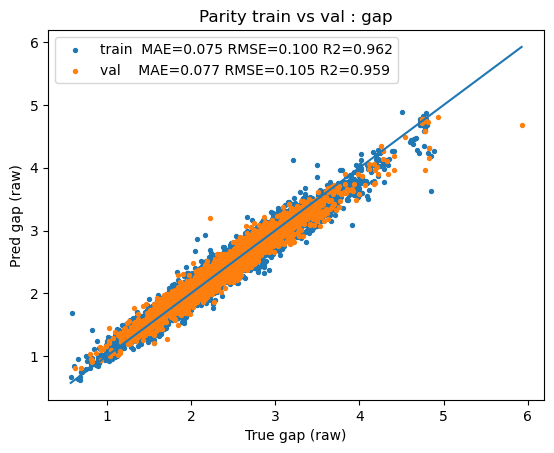

In [23]:
pred_tr, true_tr, smi_tr = predict_on_loader(model, train_loader, device, desc="predict(train)")
pred_va, true_va, smi_va = predict_on_loader(model, val_loader,   device, desc="predict(val)")
pred_te, true_te, smi_te = predict_on_loader(model, test_loader,  device, desc="predict(test)")

task_name = target_cols[0]           # example: first target
task_idx = target_cols.index(task_name)

med, iqr = scalers[task_name]

plot_parity_train_val_1task(true_tr, pred_tr,
                            true_va, pred_va,
                            task_name,
                            task_idx,
                            title=f"Parity train vs val : {task_name}",
                            max_points=20000,
                            med=med, iqr=iqr)

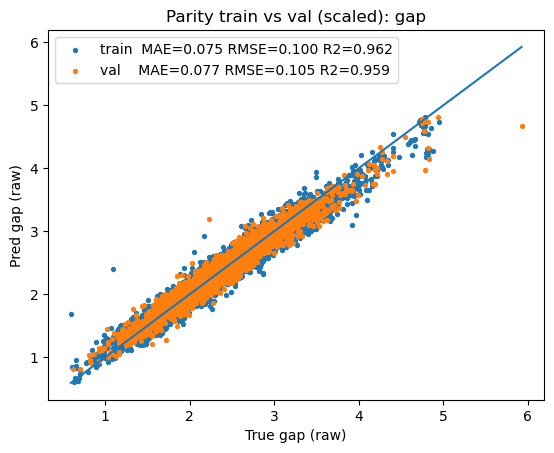

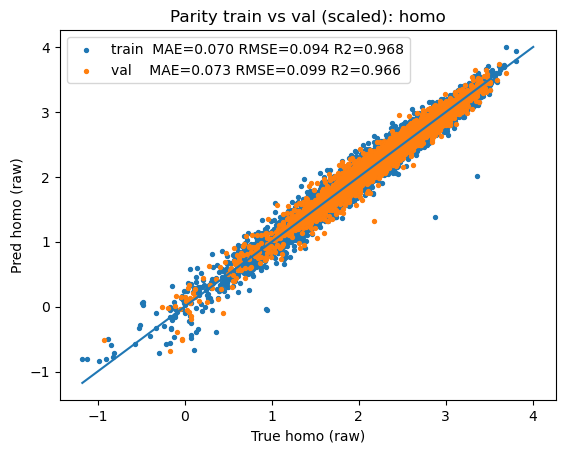

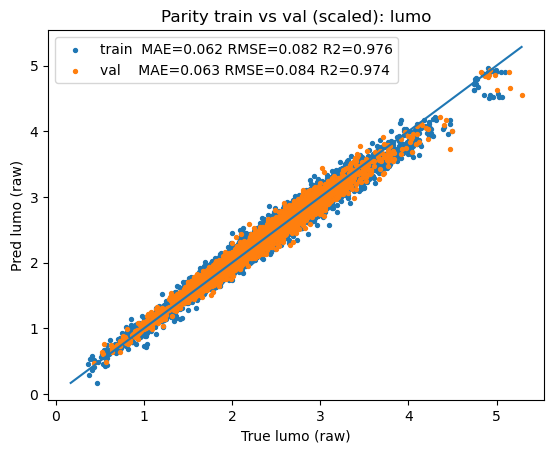

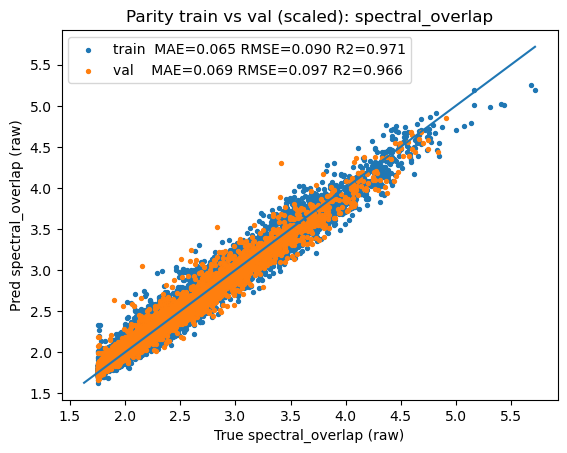

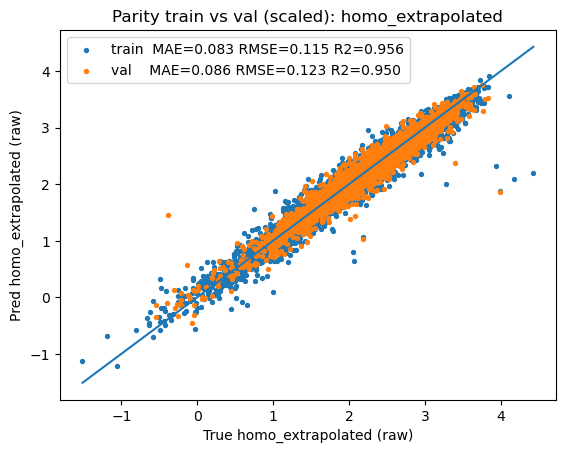

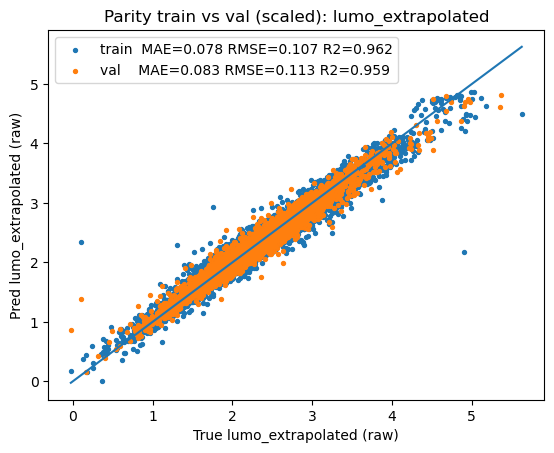

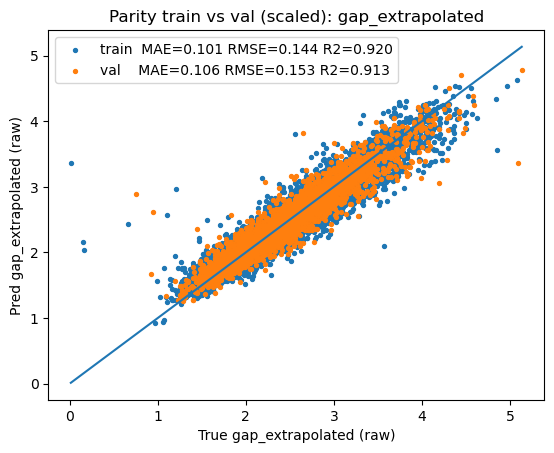

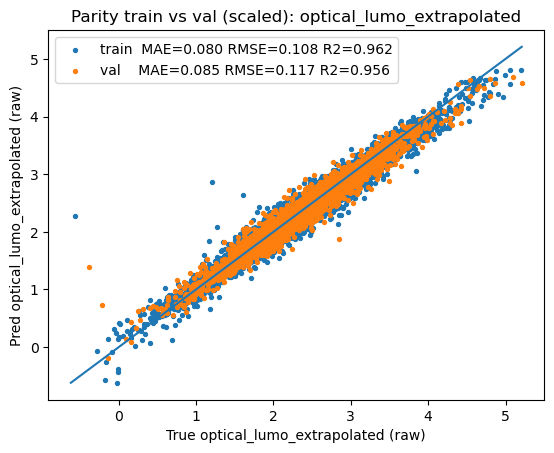

In [24]:
for task_name in target_cols:
    task_idx = target_cols.index(task_name)
    plot_parity_train_val_1task(true_tr, pred_tr, true_va, pred_va,
                                task_name, task_idx,
                                title=f"Parity train vs val (scaled): {task_name}",
                                max_points=20000,
                                med=med,
                                iqr=iqr)

## 保存

In [ ]:
# ============================================================
# A) Utilities
# ============================================================

def ensure_dir(path: str):
    """
    保存先ディレクトリを作成
    すでに存在していてもエラーにならない
    """
    os.makedirs(path, exist_ok=True)

def build_versions() -> Dict[str, str]:
    """
    checkpointに環境情報を残すための辞書を作る関数
    """
    return {
        "python": f"{os.sys.version_info.major}.{os.sys.version_info.minor}.{os.sys.version_info.micro}",
        "torch": torch.__version__,
        "torch_geometric": torch_geometric.__version__,
        "rdkit": getattr(Chem, "__version__", "unknown"),
    }

def scalers_to_serializable(scalers: Dict[str, Tuple[float, float]]) -> Dict[str, Dict[str, float]]:
    """
    robust scalerの保存
    """
    return {k: {"median": float(v[0]), "iqr": float(v[1])} for k, v in scalers.items()}

def serializable_to_scalers(d: Dict[str, Dict[str, float]]) -> Dict[str, Tuple[float, float]]:
    """
    robust scalerの復元
    """
    return {k: (float(v["median"]), float(v["iqr"])) for k, v in d.items()}

def inverse_robust_scalar(x_scaled: float, med: float, iqr: float) -> float:
    """
    推論で得たscaledの出力を元のスケールに戻す
    """
    return float(x_scaled * iqr + med)

def canonicalize_smiles(smi: str) -> Optional[str]:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol, canonical=True)

# ============================================================
# B) Preprocess registry (SMILES -> PyG Data)
#    Add new preprocessers here in the future.
# ============================================================

def smiles_to_pyg_discrete_v2(smiles: str):
    """
    smiles→RDKit Mol→PyG Data への変換関数（離散原子・結合特徴 v2）
    Your current preprocessing:
      - node features: atom_features() -> long[5]
      - edge features: bond_features() -> long[3] (0th is bond_type)
    Returns: torch_geometric.data.Data or None
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.stack([atom_features(a) for a in mol.GetAtoms()], dim=0)  # [N, 5]

    edge_index_list, edge_attr_list = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bf = bond_features(bond)
        edge_index_list += [[i, j], [j, i]]
        edge_attr_list  += [bf, bf]

    if len(edge_index_list) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr  = torch.empty((0, 3), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr  = torch.stack(edge_attr_list, dim=0)

    from torch_geometric.data import Data
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.smiles = smiles
    return data

# 文字列キー→関数の辞書
PREPROCESS_REGISTRY: Dict[str, Callable[[str], Any]] = {
    "discrete_atom_bond_v2": smiles_to_pyg_discrete_v2,
    # future:
    # "deep4chem_pair_concat": ...,
    # "3d_conformer": ...,
}

# ============================================================
# C) Model registry
#    Add new models here in the future.
# ============================================================

def build_mpnn_edgecond_gru(model_config: Dict[str, Any]):
    """
    checkpointで保存したmodel_configを使ってモデルを再構築
    Reconstruct your MPNNRegressor from config.
    """
    return MPNNRegressor(
        hidden_dim=int(model_config["hidden_dim"]),
        num_layers=int(model_config["num_layers"]),
        num_targets=int(model_config["num_targets"]),
        dropout=float(model_config.get("dropout", 0.0)),
    )

MODEL_REGISTRY: Dict[str, Callable[[Dict[str, Any]], torch.nn.Module]] = {
    "mpnn_edgecond_gru": build_mpnn_edgecond_gru,
    # future:
    # "gin": ...,
    # "gat": ...,
}

# ============================================================
# D) Generic save / load
# ============================================================

def save_checkpoint_generic(
    model: torch.nn.Module,                                 # 学習済みのPyTorchモデル
    dataset_name: str,                                      # 保存先のフォルダ名
    target_cols: List[str],                                 # 出力タスク名の順序
    scalers: Dict[str, Tuple[float, float]],                # robust scaler
    save_root: str = "models",                              # ルート
    ckpt_name: str = "checkpoint.pt",                       # チェックポイント名
    model_name: str = "mpnn_edgecond_gru",
    preprocess_name: str = "discrete_atom_bond_v2",
    model_config: Optional[Dict[str, Any]] = None,
    preprocess_config: Optional[Dict[str, Any]] = None,
):
    """
    Save a single checkpoint + optional json sidecars.

    Folder: {save_root}/{dataset_name}/
    """
    save_dir = os.path.join(save_root, dataset_name)
    ensure_dir(save_dir)

    ckpt_path = os.path.join(save_dir, ckpt_name)

    # Build minimal model_config if not provided
    if model_config is None:
        model_config = {
            "model_name": model_name,
            "hidden_dim": int(getattr(model, "layers", None)[0].hidden_dim) if hasattr(model, "layers") else 128,
            "num_layers": int(len(model.layers)) if hasattr(model, "layers") else 3,
            "dropout": float(getattr(model, "dropout", 0.0)),
            "fp_dim": int(getattr(model, "fp_dim", 1024)),
            "num_targets": int(len(target_cols)),
            "target_cols": list(target_cols),  # ORDER IS CRITICAL
        }
    else:
        # enforce critical fields
        model_config = dict(model_config)
        model_config["model_name"] = model_name
        model_config["num_targets"] = int(len(target_cols))
        model_config["target_cols"] = list(target_cols)

    if preprocess_config is None:
        preprocess_config = {
            "preprocess_name": preprocess_name,
            "smiles_canonicalize": True,
            "rdkit_sanitize": True,
        }
    else:
        preprocess_config = dict(preprocess_config)
        preprocess_config["preprocess_name"] = preprocess_name

    payload = {
        "state_dict": model.state_dict(),
        "dataset_name": dataset_name,
        "model_config": model_config,
        "preprocess_config": preprocess_config,
        "scalers": scalers_to_serializable(scalers),
        "versions": build_versions(),
    }

    torch.save(payload, ckpt_path)

    # sidecars (human-readable)
    with open(os.path.join(save_dir, "model_config.json"), "w", encoding="utf-8") as f:
        json.dump(model_config, f, indent=2, ensure_ascii=False)
    with open(os.path.join(save_dir, "preprocess_config.json"), "w", encoding="utf-8") as f:
        json.dump(preprocess_config, f, indent=2, ensure_ascii=False)
    with open(os.path.join(save_dir, "scalers.json"), "w", encoding="utf-8") as f:
        json.dump(payload["scalers"], f, indent=2, ensure_ascii=False)
    with open(os.path.join(save_dir, "versions.json"), "w", encoding="utf-8") as f:
        json.dump(payload["versions"], f, indent=2, ensure_ascii=False)

    print(f"Saved: {ckpt_path}")
    return ckpt_path

class GenericGNNPredictor:
    """
    一回ロードしたら、何度でもsmiles予測できるオブジェクト
    Load once, predict many.
    """
    def __init__(self, ckpt_path: str, device: Optional[torch.device] = None):
        self.ckpt_path = ckpt_path
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # payloadの読み込み
        payload = torch.load(ckpt_path, map_location="cpu")

        # model_config, preprocess_config, scalersの復元
        self.dataset_name = payload.get("dataset_name", "unknown")
        self.model_config = payload["model_config"]
        self.preprocess_config = payload["preprocess_config"]
        self.scalers = serializable_to_scalers(payload["scalers"])
        self.versions = payload.get("versions", {})
        self.target_cols = list(self.model_config["target_cols"])
        self.num_targets = int(self.model_config["num_targets"])

        # model_nameを見てMODEL_REGISTRYからモデルを構築
        model_name = self.model_config.get("model_name")
        if model_name not in MODEL_REGISTRY:
            raise ValueError(f"Unknown model_name='{model_name}'. Available: {list(MODEL_REGISTRY.keys())}")
        self.model = MODEL_REGISTRY[model_name](self.model_config).to(self.device)
        # state_dictをロードしてevalモードに
        self.model.load_state_dict(payload["state_dict"])
        self.model.eval()

        # preprocess_nameを見てPREPROCESS_REGISTRYから変換関数を取得
        preprocess_name = self.preprocess_config.get("preprocess_name")
        if preprocess_name not in PREPROCESS_REGISTRY:
            raise ValueError(f"Unknown preprocess_name='{preprocess_name}'. Available: {list(PREPROCESS_REGISTRY.keys())}")
        self.smiles_to_data = PREPROCESS_REGISTRY[preprocess_name]

        self.do_canonicalize = bool(self.preprocess_config.get("smiles_canonicalize", True))

    @torch.no_grad()
    def predict_smiles(self, smiles: str) -> Dict[str, Any]:
        smi_in = smiles
        smi = smiles

        if self.do_canonicalize:
            smi2 = canonicalize_smiles(smi)
            if smi2 is None:
                return {"ok": False, "smiles_in": smi_in, "error": "Invalid SMILES"}
            smi = smi2

        data = self.smiles_to_data(smi)
        if data is None:
            return {"ok": False, "smiles_in": smi_in, "smiles_used": smi, "error": "Failed to build graph"}

        # Batch of 1
        from torch_geometric.loader import DataLoader
        batch = next(iter(DataLoader([data], batch_size=1, shuffle=False))).to(self.device)

        pred_scaled = self.model(batch).detach().cpu().view(-1)  # [T]
        if pred_scaled.numel() != self.num_targets:
            return {
                "ok": False,
                "smiles_in": smi_in,
                "smiles_used": smi,
                "error": f"Pred dim mismatch: got {pred_scaled.numel()} expected {self.num_targets}"
            }

        pred_scaled_dict = {t: float(pred_scaled[i].item()) for i, t in enumerate(self.target_cols)}

        pred_raw_dict = {}
        for i, t in enumerate(self.target_cols):
            med, iqr = self.scalers[t]
            pred_raw_dict[t] = inverse_robust_scalar(float(pred_scaled[i].item()), med, iqr)

        return {
            "ok": True,
            "dataset": self.dataset_name,
            "smiles_in": smi_in,
            "smiles_used": smi,
            "pred_scaled": pred_scaled_dict,
            "pred_raw": pred_raw_dict,
        }

    @torch.no_grad()
    def predict_smiles_list(self, smiles_list: List[str]) -> pd.DataFrame:
        rows = []
        for smi in smiles_list:
            res = self.predict_smiles(smi)
            if not res["ok"]:
                rows.append({
                    "smiles_in": res.get("smiles_in", smi),
                    "smiles_used": res.get("smiles_used", ""),
                    "ok": False,
                    "error": res.get("error", "unknown"),
                })
                continue

            row = {
                "smiles_in": res["smiles_in"],
                "smiles_used": res["smiles_used"],
                "ok": True,
                "error": "",
            }
            for t in self.target_cols:
                row[t] = res["pred_raw"][t]
                row[f"{t}_scaled"] = res["pred_scaled"][t]
            rows.append(row)

        return pd.DataFrame(rows)

def load_predictor_generic(
    dataset_name: str,
    save_root: str = "models",
    ckpt_name: str = "checkpoint.pt",
    device: Optional[torch.device] = None,
) -> GenericGNNPredictor:
    ckpt_path = os.path.join(save_root, dataset_name, ckpt_name)
    return GenericGNNPredictor(ckpt_path=ckpt_path, device=device)

In [20]:
ckpt_path = save_checkpoint_generic(
    model=model,
    dataset_name="nrel",
    target_cols=target_cols,   
    scalers=scalers,           
    save_root="models",
    ckpt_name="checkpoint.pt",
    model_name="mpnn_edgecond_gru",
    preprocess_name="discrete_atom_bond_v2",
)

Saved: models/nrel/checkpoint.pt


## 復元

In [21]:
predictor = load_predictor_generic(
    dataset_name="nrel",
    save_root="models",
)

res = predictor.predict_smiles("CCO")
print(res["pred_raw"])    # {"logP":..., "qed":..., "SAS":...}

df = predictor.predict_smiles_list(["CCO", "c1ccccc1", "invalid"])
display(df)


{'gap': 5.1179975324630735, 'homo': -6.481625464229649, 'lumo': -0.7308945234565236, 'spectral_overlap': -422.84538336668584, 'homo_extrapolated': -5.616125647804598, 'lumo_extrapolated': -2.123612729482369, 'gap_extrapolated': 3.174334164434671, 'optical_lumo_extrapolated': -2.436118009988373}


[21:52:46] SMILES Parse Error: syntax error while parsing: invalid
[21:52:46] SMILES Parse Error: check for mistakes around position 1:
[21:52:46] invalid
[21:52:46] ^
[21:52:46] SMILES Parse Error: Failed parsing SMILES 'invalid' for input: 'invalid'


,smiles_in,smiles_used,ok,error,gap,gap_scaled,homo,homo_scaled,lumo,lumo_scaled,spectral_overlap,spectral_overlap_scaled,homo_extrapolated,homo_extrapolated_scaled,lumo_extrapolated,lumo_extrapolated_scaled,gap_extrapolated,gap_extrapolated_scaled,optical_lumo_extrapolated,optical_lumo_extrapolated_scaled
0,CCO,CCO,True,,5.117998,4.222862,-6.481625,-2.59109,-0.730895,2.504063,-422.845383,-1.009533,-5.616126,-1.440021,-2.123613,1.257869,3.174334,2.837219,-2.436118,1.291093
1,c1ccccc1,c1ccccc1,True,,4.724627,3.630905,-6.226287,-2.11234,-0.945121,2.199747,-155.587642,-0.904117,-5.434549,-1.120134,-1.879334,1.656055,3.168251,2.826208,-2.262361,1.587930
2,invalid,,False,Invalid SMILES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
